## Hypothesis validation notebook (IMAGE)

Dataset: `IMAGE` from `DATASET_REGISTRY` (Torchvision MNIST by default).

This notebook mirrors the synthetic/TABULAR hypothesis validation, but on a real image dataset.

**Hypothesis (operational):** In representation space $z=\\phi_\\ell(x)$, clean samples exhibit class-conditional local regularity. Adversarial samples are enriched among points showing decision–geometry inconsistency (e.g., class-mixed neighborhoods; atypical for predicted class relative to alternatives).

Notes for local runtime:
- MNIST is larger; we cap PH scoring with `MAX_POINTS_FOR_SCORING`.
- `IMAGE` requires `torchvision` and (unless already present) an MNIST download.
- You can set `cfg.data.root` and `cfg.data.download=True` below.


In [4]:
import pathlib
import sys
import time
from dataclasses import replace

import numpy as np
import matplotlib.pyplot as plt

repo_root = pathlib.Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from src.api import (
    get_dataset,
    get_model,
    train,
    generate_adversarial,
    compute_scores,
    concat_scores,
    fit_detector,
)
from src.evaluation import evaluate_detector
from src.models import get_model_predictions, extract_features_batch
from src.utils import ExperimentConfig, DataConfig, ModelConfig, AttackConfig, GraphConfig, DetectorConfig
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


### Config (MNIST-friendly)

You may need to set `download=True` if MNIST isn't present under `root`.


In [5]:
SEED = 42
MAX_POINTS_FOR_SCORING = 200

cfg_base = ExperimentConfig(
    seed=SEED,
    device='cpu',
    data=DataConfig(
        train_ratio=0.8,
        val_ratio=0.2,
        test_ratio=0.0,  # torchvision datasets already have test split; registry uses it
        root='./data',
        download=False,
    ),
    model=ModelConfig(epochs=2, batch_size=128, learning_rate=1e-3, weight_decay=1e-4),
    attack=AttackConfig(attack_type='fgsm', epsilon=0.1),
    graph=GraphConfig(
        space='feature',
        feature_layer='penultimate',
        use_topology=True,
        topo_k=30,
        topo_preprocess='pca',
        topo_pca_dim=10,
        topo_maxdim=1,
        topo_neighbor_mode='global',
        topo_metric_normalization='none',
        topo_whiten_ridge=1e-3,
        topo_k_list=None,
    ),
    detector=DetectorConfig(
        detector_type='topology_score',
        topo_percentile=95.0,
        topo_cov_shrinkage=1e-3,
        topo_class_conditional=False,
        topo_class_scoring_mode='min_over_classes',
        topo_min_clean_per_class=5,
    ),
)
cfg_base


ExperimentConfig(data=DataConfig(n_samples=1000, noise=0.1, random_state=42, train_ratio=0.8, val_ratio=0.2, test_ratio=0.0, root='./data', download=False), model=ModelConfig(input_dim=2, hidden_dims=[64, 32], output_dim=2, activation='relu', learning_rate=0.001, epochs=2, batch_size=128, weight_decay=0.0001, random_state=42), attack=AttackConfig(attack_type='fgsm', epsilon=0.1, num_steps=10, step_size=0.01, random_start=True), ood=OODConfig(enabled=False, method='feature_shuffle', severity=1.0, seed=None, batch_size=128, patch_size=4, blur_kernel_size=5, blur_sigma=1.0, saltpepper_p=0.05), graph=GraphConfig(k=10, sigma=None, space='feature', feature_layer='penultimate', normalized_laplacian=True, use_diffusion=False, diffusion_components=10, use_tangent=True, tangent_k=20, tangent_dim=None, tangent_var_threshold=0.9, tangent_dim_min=2, tangent_dim_max=None, use_topology=True, topo_k=30, topo_maxdim=1, topo_metric='euclidean', topo_thresh=None, topo_min_persistence=1e-06, topo_preproce

### Load dataset + train model once

In [6]:
bundle = get_dataset('IMAGE', cfg_base, overrides={"download": True})
num_classes = int(bundle.meta.get('num_classes', 10))
in_channels = int(bundle.X_train.shape[1])

model = get_model('CNN', cfg_base, num_classes=num_classes, in_channels=in_channels)
trained = train(model, bundle, cfg_base, device=cfg_base.device, verbose=True, return_history=False)

clip = bundle.meta.get('clip', (0.0, 1.0))
X_adv_val = generate_adversarial(trained, bundle.X_val, bundle.y_val, cfg_base, clip=clip)
X_adv_test = generate_adversarial(trained, bundle.X_test, bundle.y_test, cfg_base, clip=clip)

print('Train/val/test shapes:', bundle.X_train.shape, bundle.X_val.shape, bundle.X_test.shape)


100.0%
100.0%
100.0%
100.0%


Train/val/test shapes: (48000, 1, 28, 28) (12000, 1, 28, 28) (10000, 1, 28, 28)


### Visual sanity check: clean vs adversarial images

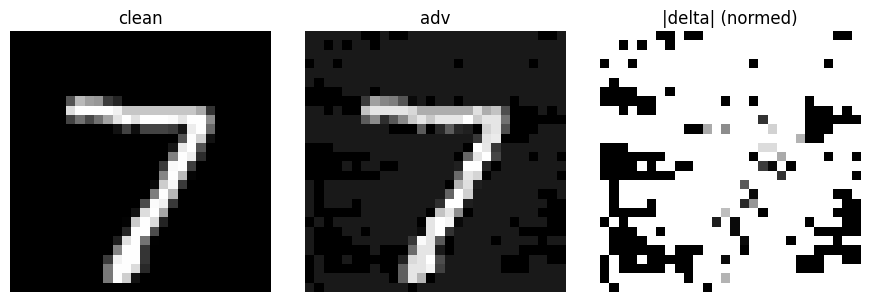

In [7]:
def _show(img, ax, title=''):
    x = np.asarray(img)
    # MNIST is (C,H,W) with C=1
    if x.ndim == 3 and x.shape[0] in {1,3}:
        x2 = np.transpose(x, (1,2,0))
        if x2.shape[2] == 1:
            x2 = x2[:,:,0]
    else:
        x2 = x
    ax.imshow(x2, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

i = 0
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
_show(bundle.X_test[i], axes[0], 'clean')
_show(X_adv_test[i], axes[1], 'adv')
delta = np.abs(X_adv_test[i] - bundle.X_test[i])
_show(delta / (delta.max() + 1e-12), axes[2], '|delta| (normed)')
plt.tight_layout()
plt.show()


### Subsample points for PH scoring (runtime control)

In [8]:
rng = np.random.default_rng(SEED)

def _subsample(X, y, n_max: int):
    X = np.asarray(X)
    y = np.asarray(y, dtype=int)
    if len(X) <= n_max:
        return X, y
    idx = rng.choice(np.arange(len(X)), size=int(n_max), replace=False)
    return X[idx], y[idx]

X_val_clean_used, y_val_clean_used = _subsample(bundle.X_val, bundle.y_val, MAX_POINTS_FOR_SCORING)
X_val_adv_used, y_val_adv_used = _subsample(X_adv_val, bundle.y_val, MAX_POINTS_FOR_SCORING)
X_test_clean_used, y_test_clean_used = _subsample(bundle.X_test, bundle.y_test, MAX_POINTS_FOR_SCORING)
X_test_adv_used, y_test_adv_used = _subsample(X_adv_test, bundle.y_test, MAX_POINTS_FOR_SCORING)

print('Val used:', X_val_clean_used.shape, X_val_adv_used.shape)
print('Test used:', X_test_clean_used.shape, X_test_adv_used.shape)


Val used: (200, 1, 28, 28) (200, 1, 28, 28)
Test used: (200, 1, 28, 28) (200, 1, 28, 28)


In [9]:
def _needs_y_pred(det_cfg: DetectorConfig) -> bool:
    if not bool(getattr(det_cfg, 'topo_class_conditional', False)):
        return False
    m = str(getattr(det_cfg, 'topo_class_scoring_mode', 'min_over_classes')).strip().lower()
    return m in {'predicted_class', 'pred', 'contrastive_pred_gap', 'contrastive', 'pred_gap'}


def run_variant(*, name: str, cfg: ExperimentConfig):
    t0 = time.perf_counter()

    scores_val_clean = compute_scores(X_val_clean_used, trained, bundle=bundle, cfg=cfg)
    scores_val_adv = compute_scores(X_val_adv_used, trained, bundle=bundle, cfg=cfg)
    scores_test_clean = compute_scores(X_test_clean_used, trained, bundle=bundle, cfg=cfg)
    scores_test_adv = compute_scores(X_test_adv_used, trained, bundle=bundle, cfg=cfg)

    scores_val_all = concat_scores(scores_val_clean, scores_val_adv)
    any_key = next(iter(scores_val_all.keys()))
    labels_val = np.concatenate([
        np.zeros(len(scores_val_clean[any_key]), dtype=int),
        np.ones(len(scores_val_adv[any_key]), dtype=int)
    ])
    y_val_all = np.concatenate([np.asarray(y_val_clean_used, dtype=int), np.asarray(y_val_adv_used, dtype=int)])

    y_pred_val_all = None
    if _needs_y_pred(cfg.detector):
        y_pred_val_clean = get_model_predictions(trained, np.asarray(X_val_clean_used), device=str(cfg.device), return_probs=False)
        y_pred_val_adv = get_model_predictions(trained, np.asarray(X_val_adv_used), device=str(cfg.device), return_probs=False)
        y_pred_val_all = np.concatenate([np.asarray(y_pred_val_clean, dtype=int), np.asarray(y_pred_val_adv, dtype=int)])

    detector = fit_detector(scores_val_all, labels_val, cfg, y_true=y_val_all, y_pred=y_pred_val_all)

    scores_test_all = concat_scores(scores_test_clean, scores_test_adv)
    any_key_t = next(iter(scores_test_all.keys()))
    labels_test = np.concatenate([
        np.zeros(len(scores_test_clean[any_key_t]), dtype=int),
        np.ones(len(scores_test_adv[any_key_t]), dtype=int)
    ])

    y_pred_test_all = None
    if _needs_y_pred(cfg.detector):
        y_pred_test_clean = get_model_predictions(trained, np.asarray(X_test_clean_used), device=str(cfg.device), return_probs=False)
        y_pred_test_adv = get_model_predictions(trained, np.asarray(X_test_adv_used), device=str(cfg.device), return_probs=False)
        y_pred_test_all = np.concatenate([np.asarray(y_pred_test_clean, dtype=int), np.asarray(y_pred_test_adv, dtype=int)])

    try:
        raw_scores_test = detector.score(scores_test_all, y_pred=y_pred_test_all)
    except TypeError:
        raw_scores_test = detector.score(scores_test_all)

    thr = float(getattr(detector, 'threshold', np.nan))
    metrics = evaluate_detector(np.asarray(labels_test, dtype=int), np.asarray(raw_scores_test, dtype=float), threshold=thr)
    wall = time.perf_counter() - t0

    return {
        'name': str(name),
        'cfg': cfg,
        'detector': detector,
        'scores_test_all': scores_test_all,
        'labels_test': labels_test,
        'raw_scores_test': np.asarray(raw_scores_test, dtype=float),
        'threshold': thr,
        'metrics': metrics,
        'wall_s': float(wall),
        'y_pred_test_all': y_pred_test_all,
    }


### Variants + run

In [10]:
variants = []
cfg_v0 = cfg_base
variants.append(('V0_pooled_global', cfg_v0))

cfg_v1 = replace(cfg_base, detector=replace(cfg_base.detector, topo_class_conditional=True, topo_class_scoring_mode='min_over_classes'))
variants.append(('V1_classcond_global', cfg_v1))

cfg_v2 = replace(cfg_v1, graph=replace(cfg_v1.graph, topo_neighbor_mode='class_pred'))
variants.append(('V2_classcond_classPredNbr', cfg_v2))

cfg_v3 = replace(cfg_v2, graph=replace(cfg_v2.graph, topo_metric_normalization='whiten', topo_whiten_ridge=1e-3))
variants.append(('V3_classPredNbr_whiten', cfg_v3))

cfg_v4 = replace(cfg_v3, detector=replace(cfg_v3.detector, topo_class_scoring_mode='contrastive_pred_gap'))
variants.append(('V4_contrastive_gap', cfg_v4))

results = []
for name, cfg in variants:
    print('Running', name)
    r = run_variant(name=name, cfg=cfg)
    results.append(r)
    m = r['metrics']
    print('  roc_auc=', m.get('roc_auc'), 'pr_auc=', m.get('pr_auc'), 'fpr@95=', m.get('fpr_at_tpr95'), 'wall_s=', r['wall_s'])

[(r['name'], float(r['metrics']['roc_auc'])) for r in results]


Running V0_pooled_global


KeyboardInterrupt: 

### ROC curves

In [ ]:
plt.figure(figsize=(6, 5))
for r in results:
    fpr = np.asarray(r['metrics']['fpr'])
    tpr = np.asarray(r['metrics']['tpr'])
    auc = float(r['metrics']['roc_auc'])
    plt.plot(fpr, tpr, label=f"{r['name']} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves (IMAGE: clean vs adversarial)')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()


### Score distributions

In [ ]:
ncols = 2
nrows = int(np.ceil(len(results) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4*nrows), squeeze=False)

for ax, r in zip(axes.ravel(), results):
    y = np.asarray(r['labels_test'], dtype=int)
    s = np.asarray(r['raw_scores_test'], dtype=float)
    thr = float(r['threshold'])
    ax.hist(s[y == 0], bins=40, alpha=0.6, label='clean', density=True)
    ax.hist(s[y == 1], bins=40, alpha=0.6, label='adv', density=True)
    ax.axvline(thr, color='k', linestyle='--', linewidth=1)
    ax.set_title(f"{r['name']}\nAUC={float(r['metrics']['roc_auc']):.3f}")
    ax.set_xlabel('detector score')
    ax.set_ylabel('density')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2)

for ax in axes.ravel()[len(results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()
